In [1]:
# Patikriname kokie yra stulpelių pavadinimai
with open("breast-cancer-wisconsin.names", "r") as f:
    print(f.read())


Citation Request:
   This breast cancer databases was obtained from the University of Wisconsin
   Hospitals, Madison from Dr. William H. Wolberg.  If you publish results
   when using this database, then please include this information in your
   acknowledgements.  Also, please cite one or more of:

   1. O. L. Mangasarian and W. H. Wolberg: "Cancer diagnosis via linear 
      programming", SIAM News, Volume 23, Number 5, September 1990, pp 1 & 18.

   2. William H. Wolberg and O.L. Mangasarian: "Multisurface method of 
      pattern separation for medical diagnosis applied to breast cytology", 
      Proceedings of the National Academy of Sciences, U.S.A., Volume 87, 
      December 1990, pp 9193-9196.

   3. O. L. Mangasarian, R. Setiono, and W.H. Wolberg: "Pattern recognition 
      via linear programming: Theory and application to medical diagnosis", 
      in: "Large-scale numerical optimization", Thomas F. Coleman and Yuying
      Li, editors, SIAM Publications, Philadelphia 199

In [2]:
import pandas as pd

# Nurodome stulpelių pavadinimus
column_names = [
    "ID", "Clump Thickness", "Uniformity of Cell Size", "Uniformity of Cell Shape",
    "Marginal Adhesion", "Single Epithelial Cell Size", "Bare Nuclei",
    "Bland Chromatin", "Normal Nucleoli", "Mitoses", "Class"
]

# Nuskaitome duomenis ir nurodome, kad tušti duomenys yra pažymėti "?"
df = pd.read_csv("breast-cancer-wisconsin.data", names=column_names, na_values="?")

# Pasiverčiam visus duomenis iš duomenų masyvo formatą į skaitinį
for column in df.columns:
    df[column] = pd.to_numeric(df[column], errors="coerce")
        
# Atvaizduojame pirmas duomenų eilutes
df.head()


,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1.0,3,1,1,2
1,1002945,5,4,4,5,7,10.0,3,2,1,2
2,1015425,3,1,1,1,2,2.0,3,1,1,2
3,1016277,6,8,8,1,3,4.0,3,7,1,2
4,1017023,4,1,1,3,2,1.0,3,1,1,2


In [3]:
# Patikriname tuščių reikšmių skaičių ir jei tokių randame - jas ištriname.
print(df.isnull().sum())

ID                              0
Clump Thickness                 0
Uniformity of Cell Size         0
Uniformity of Cell Shape        0
Marginal Adhesion               0
Single Epithelial Cell Size     0
Bare Nuclei                    16
Bland Chromatin                 0
Normal Nucleoli                 0
Mitoses                         0
Class                           0
dtype: int64


In [4]:
# Kadangi radome tuščių reikšmių, mes jas ištriname
df.dropna(inplace=True)
print(df.isnull().sum())

ID                             0
Clump Thickness                0
Uniformity of Cell Size        0
Uniformity of Cell Shape       0
Marginal Adhesion              0
Single Epithelial Cell Size    0
Bare Nuclei                    0
Bland Chromatin                0
Normal Nucleoli                0
Mitoses                        0
Class                          0
dtype: int64


In [5]:
# Pakeičiame klasių reikšmes iš 2 -> 0 ir 4 -> 1
# df["Class"] = pd.to_numeric(df["Class"], errors="coerce") # pakeičiame stulpelio formatą į skaitinį
df["Class"] = df["Class"].map({2: 0, 4: 1})

# Išmetame ID reikšmę, kurios mes nenaudosime.
df.drop(columns=["ID"], inplace=True)

df.head()
print(df["Class"].unique())


[0 1]


In [6]:
# Išmaišome duomenis
df = df.sample(frac=1, random_state=11).reset_index(drop=True)
df.head()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,8,8,9,6,6,3.0,10,10,1,1
1,3,1,1,1,2,1.0,1,1,1,0
2,7,5,6,3,3,8.0,7,4,1,1
3,3,1,1,1,2,1.0,1,1,1,0
4,4,1,3,3,2,1.0,1,1,1,0


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Normalizuojame požymius
scaler = StandardScaler()
X = scaler.fit_transform(df.drop(columns=["Class"]))
X = np.c_[X, np.ones(X.shape[0])] # Pridedame bias (papildomą stulpelį su 1)
Y = df["Class"].values

# Padalijame duomenis testavimui
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)


In [55]:
import matplotlib.pyplot as plt


def sigmoid_function(a): #aprasoma sigmoidine funkcija
    return 1/(1 + np.exp(-a))
    

def classify(y): # Funkcija, kuri apvalina išeigą (0 arba 1)
    return 1 if y >= 0.5 else 0


# Apsirašome du metodus: paketinį gradientinį nusileidimą ir stochastinį gradientinį nusileidimą
# Stochastinis gradientinis nusileidimas
def stochastic_gradient_descent(X, T, lr, epochs, Emin):
    m, n = X.shape
    W = np.random.randn(n)  # Pradiniai svoriai
    totalError = np.inf
    epoch = 0
    errors_train = []
    errors_val = []
    accuracies_train = []
    accuracies_val = []
    
    while totalError > Emin and epoch < epochs:
        totalError = 0
        correct_train = 0
        for i in range(m):
            y = sigmoid_function(np.dot(W, X[i]))  # Skaičiuojamas neurono išėjimas
            error = T[i] - y
            for k in range(n):
                W[k] += lr * error * X[i][k]  # Atnaujinami svoriai
            totalError += error ** 2  # Kaupiama klaida
            
            if classify(y) == T[i]:
                correct_train += 1

        epoch += 1
        errors_train.append(totalError)
        accuracies_train.append(correct_train / m)

        # Validavimas
        val_predictions = np.array([classify(sigmoid_function(np.dot(W, X_val[i]))) for i in range(len(X_val))])
        val_error = np.sum((Y_val - val_predictions) ** 2)  # Validavimo klaida
        errors_val.append(val_error)
        accuracies_val.append(np.mean(val_predictions == Y_val))
    
    return W, errors_train, errors_val, accuracies_train, accuracies_val

# Paketinis gradientinis nusileidimas
def batch_gradient_descent(X, T, lr, epochs, Emin):
    m, n = X.shape
    W = np.random.randn(n)  # Pradiniai svoriai
    totalError = np.inf
    epoch = 0
    errors_train = []
    errors_val = []
    accuracies_train = []
    accuracies_val = []

    while totalError > Emin and epoch < epochs:
        totalError = 0
        indices = np.random.permutation(m)
        X, T = X[indices], T[indices]
        correct_train = 0
        gradient_sum = np.zeros(n)  # Gradientų suma
        for i in range(m):
            y = sigmoid_function(np.dot(W, X[i]))  # Skaičiuojamas neurono išėjimas
            error = T[i] - y
            totalError += error ** 2  # Kaupiama klaida
            
            
            # Atnaujiname gradientų sumą
            for k in range(n):
                gradient_sum[k] += error * X[i][k]

            if classify(y) == T[i]:
                correct_train += 1

        # Atnaujiname svorius
        for k in range(n):
            W[k] += lr * (gradient_sum[k] / m)

        epoch += 1
        errors_train.append(totalError)
        accuracies_train.append(correct_train / m)

        # Validavimas
        val_predictions = np.array([classify(sigmoid_function(np.dot(W, x))) for x in X_val])
        val_error = np.sum((Y_val - val_predictions) ** 2)
        errors_val.append(val_error)
        accuracies_val.append(np.mean(val_predictions == Y_val))
    
    return W, errors_train, errors_val, accuracies_train, accuracies_val

# Nustatome parametrus
lr = 0.025 # Mokymosi greitis (geriausias 0.025) (blogiausias 0.00000000000001)
epochs = 100  # Epochos
Emin = 0.0011  # Klaidos riba

import time

# Mokome neuroną su stochastiniu gradientiniu nusileidimu
start_time = time.time()
W_sgd, errors_train_sgd, errors_val_sgd, acc_train_sgd, acc_val_sgd = stochastic_gradient_descent(X_train, Y_train, lr, epochs, Emin)
end_time = time.time()
print(f"Neurono mokymosi laikas naudojant stochastinį gradientinį nusileidimą: {end_time - start_time:.2f} s")

start_time, end_time = 0, 0
# Mokome neuroną su stochastiniu gradientiniu nusileidimu
start_time = time.time()
W_bgd, errors_train_bgd, errors_val_bgd, acc_train_bgd, acc_val_bgd = batch_gradient_descent(X_train, Y_train, lr, epochs, Emin)
end_time = time.time()
print(f"Neurono mokymosi laikas naudojant paketinį gradientinį nusileidimą: {end_time - start_time:.2f} s")
print("\n")

# Apskaičiuojame testavimo paklaidą ir tikslumą
# Apskaičiuojame testavimo paklaidą testuojant su stochastiniu gradientiniu nusileidimu
test_predictions_sgd = np.array([classify(sigmoid_function(np.dot(W_sgd, x))) for x in X_test])
test_error_sgd = np.sum((Y_test - test_predictions_sgd) ** 2)
accuracy_sgd = np.mean(test_predictions_sgd == Y_test)
print(f"Testavimo paklaida naudojant stochastinį gradientinį nusileidimą: {test_error_sgd}")
print(f"Testavimo tikslumas naudojant stochastinį gradientinį nusileidimą: {accuracy_sgd * 100:.2f}%")

# Apskaičiuojame testavimo paklaidą testuojant su paketiniu gradientiniu nusileidimu
test_predictions_bgd = np.array([classify(sigmoid_function(np.dot(W_bgd, x))) for x in X_test])
test_error_bgd = np.sum((Y_test - test_predictions_bgd) ** 2)
accuracy_bgd = np.mean(test_predictions_bgd == Y_test)

print(f"Testavimo paklaida naudojant paketinį gradientinį nusileidimą: {test_error_bgd}")
print(f"Testavimo tikslumas naudojant paketinį gradientinį nusileidimą: {accuracy_bgd * 100:.2f}% '\n")

# Skirtingų mokymosi greičių palyginimas
learning_rates = [0.00001, 0.025, 0.5, 0.75, 0.999]
results_stochastic = {}
results_batch = {}

for lr in learning_rates:
    _, errors_train, errors_val, acc_train, acc_val = stochastic_gradient_descent(X_train, Y_train, lr, epochs, Emin)
    results_stochastic[lr] = (round(errors_train[-1], 3), round(errors_val[-1], 3), round(acc_train[-1], 3), round(acc_val[-1], 3))

for lr in learning_rates:
    _, errors_train, errors_val, acc_train, acc_val = batch_gradient_descent(X_train, Y_train, lr, epochs, Emin)
    results_batch[lr] = (round(errors_train[-1], 3), round(errors_val[-1], 3), round(acc_train[-1], 3), round(acc_val[-1], 3))

# Atvaizduojame lentelę su rezultatais
print("Stochastinio gradientinio nusileidimo rezultatų priklausomybė nuo mokymo greičio")
results_df1 = pd.DataFrame(results_stochastic, index=["Mokymo klaida", "Validavimo klaida", "Mokymo tikslumas", "Validavimo tikslumas"])
print(results_df1)
print('\n')

print("Paketinio gradientinio nusileidimo rezultatų priklausomybė nuo mokymo greičio")
results_df2 = pd.DataFrame(results_batch, index=["Mokymo klaida", "Validavimo klaida", "Mokymo tikslumas", "Validavimo tikslumas"])
print(results_df2)


Neurono mokymosi laikas naudojant stochastinį gradientinį nusileidimą: 1.14 s
Neurono mokymosi laikas naudojant paketinį gradientinį nusileidimą: 1.01 s


Testavimo paklaida naudojant stochastinį gradientinį nusileidimą: 0
Testavimo tikslumas naudojant stochastinį gradientinį nusileidimą: 100.00%
Testavimo paklaida naudojant paketinį gradientinį nusileidimą: 4
Testavimo tikslumas naudojant paketinį gradientinį nusileidimą: 94.20% '

Stochastinio gradientinio nusileidimo rezultatų priklausomybė nuo mokymo greičio
                      0.00001  0.02500  0.50000  0.75000  0.99900
Mokymo klaida          16.943   12.621   15.570   16.554   18.051
Validavimo klaida       2.000    2.000    3.000    3.000    4.000
Mokymo tikslumas        0.963    0.965    0.960    0.962    0.963
Validavimo tikslumas    0.971    0.971    0.956    0.956    0.941


Paketinio gradientinio nusileidimo rezultatų priklausomybė nuo mokymo greičio
                      0.00001  0.02500  0.50000  0.75000  0.99900
Mokymo

### Vizualizacija

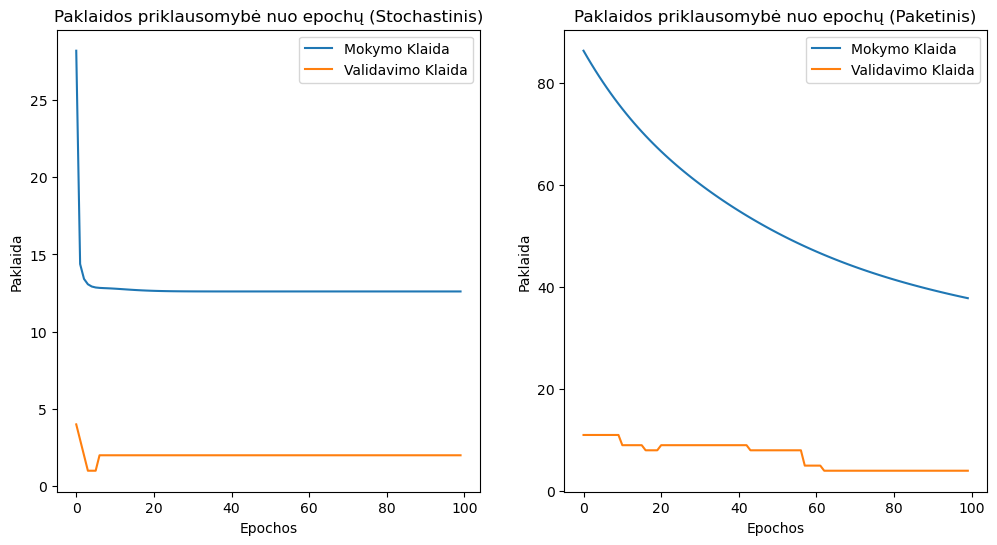

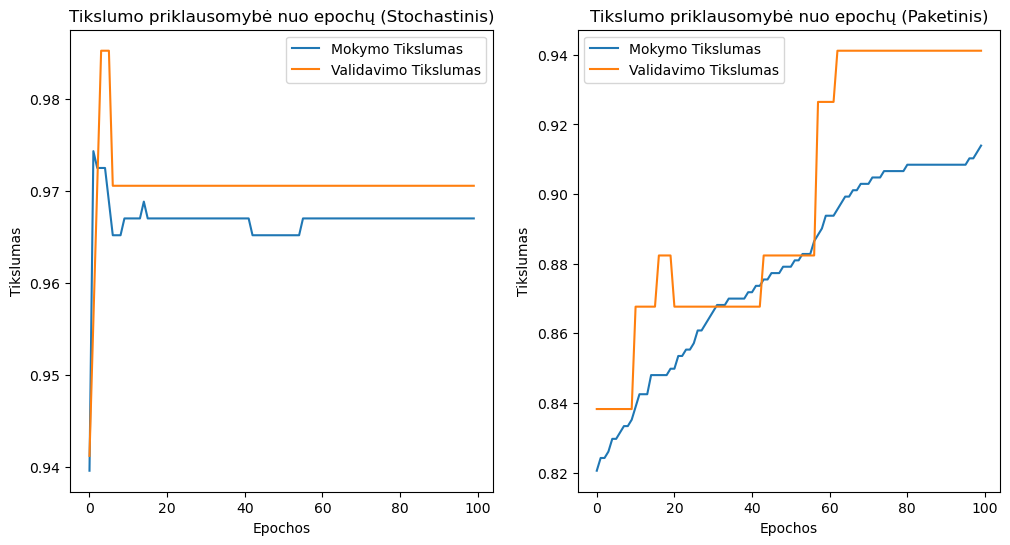

In [57]:
# Klaidos priklausomybė nuo epochų

# Stochastinis gradientinis nusileidimas
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), errors_train_sgd, label="Mokymo Klaida")
plt.plot(range(epochs), errors_val_sgd, label="Validavimo Klaida")
plt.xlabel("Epochos")
plt.ylabel("Paklaida")
plt.title("Paklaidos priklausomybė nuo epochų (Stochastinis)")
plt.legend()


# Paketinis gradientinis nusileidimas
plt.subplot(1, 2, 2)
plt.plot(range(epochs), errors_train_bgd, label="Mokymo Klaida")
plt.plot(range(epochs), errors_val_bgd, label="Validavimo Klaida")
plt.xlabel("Epochos")
plt.ylabel("Paklaida")
plt.title("Paklaidos priklausomybė nuo epochų (Paketinis)")
plt.legend()
plt.show()


# Klasifikavimo tikslumo priklausomybė nuo epochų

# Stochastinis gradientinis nusileidimas
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc_train_sgd, label="Mokymo Tikslumas")
plt.plot(range(epochs), acc_val_sgd, label="Validavimo Tikslumas")
plt.xlabel("Epochos")
plt.ylabel("Tikslumas")
plt.title("Tikslumo priklausomybė nuo epochų (Stochastinis)")
plt.legend()

# Paketinis gradientinis nusileidimas
plt.subplot(1, 2, 2)
plt.plot(range(epochs), acc_train_bgd, label="Mokymo Tikslumas")
plt.plot(range(epochs), acc_val_bgd, label="Validavimo Tikslumas")
plt.xlabel("Epochos")
plt.ylabel("Tikslumas")
plt.title("Tikslumo priklausomybė nuo epochų (Paketinis)")
plt.legend()
plt.show()

In [63]:
# 1. Svoriai, epochų skaičius
print("Stochastinio gradientinio nusileidimo svoriai:", W_sgd)
print("\n Paketinio gradientinio nusileidimo svoriai:", W_bgd)
print(f"\n Stochastinio gradientinio nusileidimo epochų skaičius: {len(errors_train_sgd)}")
print(f"\n Paketinio gradientinio nusileidimo epochų skaičius: {len(errors_train_bgd)}")

# 2. Paklaidos paskutinėje epochoje
print(f"\n Stochastinis gradientinis nusileidimas, klaida paskutinėje epochoje (mokymo): {errors_train_sgd[-1]}")
print(f"\n Stochastinis gradientinis nusileidimas, klaida paskutinėje epochoje (validavimo): {errors_val_sgd[-1]}")
print(f"\n Paketinis gradientinis nusileidimas, klaida paskutinėje epochoje (mokymo): {errors_train_bgd[-1]}")
print(f"\n Paketinis gradientinis nusileidimas, klaida paskutinėje epochoje (validavimo): {errors_val_bgd[-1]}")

# 3. Tikslumas paskutinėje epochoje
print(f"\n Stochastinis gradientinis nusileidimas, tikslumas paskutinėje epochoje (mokymo): {acc_train_sgd[-1] * 100:.2f}%")
print(f"\n Stochastinis gradientinis nusileidimas, tikslumas paskutinėje epochoje (validavimo): {acc_val_sgd[-1] * 100:.2f}%")
print(f"\n Paketinis gradientinis nusileidimas, tikslumas paskutinėje epochoje (mokymo): {acc_train_bgd[-1] * 100:.2f}%")
print(f"\n Paketinis gradientinis nusileidimas, tikslumas paskutinėje epochoje (validavimo): {acc_val_bgd[-1] * 100:.2f}%")

# 4. Paklaida ir tikslumas testavimo duomenims
print(f"\n Testavimo paklaida naudojant stochastinį gradientinį nusileidimą: {test_error_sgd}")
print(f"\n Testavimo tikslumas naudojant stochastinį gradientinį nusileidimą: {accuracy_sgd * 100:.2f}%")
print(f"\n Testavimo paklaida naudojant paketinį gradientinį nusileidimą: {test_error_bgd}")
print(f"\n Testavimo tikslumas naudojant paketinį gradientinį nusileidimą: {accuracy_bgd * 100:.2f}%")

# 5. Kiekvieno testavimo duomenų įrašo klasės
print("\n Stochastinis gradientinis nusileidimas, klasifikacija kiekvienam testavimo įrašui:")
for i, (pred, true) in enumerate(zip(test_predictions_sgd, Y_test)):
    print(f"Testavimo įrašas {i + 1}: Predikcija = {pred}, Tikroji klasė = {true}")

print("\n Paketinis gradientinis nusileidimas, klasifikacija kiekvienam testavimo įrašui:")
for i, (pred, true) in enumerate(zip(test_predictions_bgd, Y_test)):
    print(f"Testavimo įrašas {i + 1}: Predikcija = {pred}, Tikroji klasė = {true}")


Stochastinio gradientinio nusileidimo svoriai: [ 1.36022749 -0.22480514  1.03812619  0.91025723  0.43779954  1.43929864
  0.9313712   0.58039065  0.88353332 -1.02462255]

 Paketinio gradientinio nusileidimo svoriai: [ 1.15488152  0.18007466  0.26292061  1.70174691  0.72328467 -0.90578848
  1.17783524  0.74168154 -1.58114759 -0.55475143]

 Stochastinio gradientinio nusileidimo epochų skaičius: 100

 Paketinio gradientinio nusileidimo epochų skaičius: 100

 Stochastinis gradientinis nusileidimas, klaida paskutinėje epochoje (mokymo): 12.604496844512665

 Stochastinis gradientinis nusileidimas, klaida paskutinėje epochoje (validavimo): 2

 Paketinis gradientinis nusileidimas, klaida paskutinėje epochoje (mokymo): 37.78544025272339

 Paketinis gradientinis nusileidimas, klaida paskutinėje epochoje (validavimo): 4

 Stochastinis gradientinis nusileidimas, tikslumas paskutinėje epochoje (mokymo): 96.70%

 Stochastinis gradientinis nusileidimas, tikslumas paskutinėje epochoje (validavimo): 97